In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from natsort import natsorted
import sys
import pickle
import seaborn as sns

# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))



In [3]:
num_robot = 24
fieldsPerKilobot = 6
experiment_time = 1800
num_run = 100

In [4]:
bin_edges = np.arange(1,22,2)

In [5]:
results_folders = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptiveTimeout/'

In [6]:
if not os.path.isdir(results_folders):
    print(colored("Error, " + results_folders + " does not exist", 'red'))
else:
    print(colored("OK, " + results_folders + " exists", 'green'))

OK, /home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptiveTimeout/ exists


### kiloLOG labels

In [7]:
kiloLOG_label = ['time']
for i in range(0, num_robot*fieldsPerKilobot, fieldsPerKilobot):
    kiloLOG_label += ['id' + str(i // fieldsPerKilobot), 'posx' + str(i // fieldsPerKilobot), 'posy' + str(i // fieldsPerKilobot), 'ori' + str(i // fieldsPerKilobot), 'timer' + str(i // fieldsPerKilobot), 'state' + str(i // fieldsPerKilobot)]

In [8]:
def get_histogram(distribution_history, bins):
    hist_val = np.array([])
    for x in distribution_history.T:
    #     print(x.size)
        hist,_= np.histogram(x,bins) 
#         print(x)
#         print(hist/np.count_nonzero(~np.isnan(x)), end='\n\n')
        hist_val = np.vstack([hist_val, hist/np.count_nonzero(~np.isnan(x))]) if hist_val.size else hist/np.count_nonzero(~np.isnan(x))

    print(hist_val.shape)
    return hist_val

def plot_heatmap(histogram,bins,imgName, regionSide):
    fig = plt.figure(figsize=(20, 5), dpi=160)

    y_values = histogram.T
    y_edges = bins.round(decimals=2)

    # plt.xlabel('time(s)')
    yticks = y_edges


    # print("\t v_max:", v_max)
    ax = sns.heatmap(y_values, yticklabels=yticks, cmap="viridis", vmin=0, vmax=1)
    ax.set_title("Timeout distribution in "+regionSide+" region")
    ax.set_xlabel('time(s)')
    plt.ylabel('timeout')
    plt.yticks(np.arange(y_edges.size), yticks)
    fileName = "adaptiveTimeout_timeoutDistribution_"+regionSide+"_"+imgName+".png"
    print(fileName)
    
    plt.savefig(fileName)
    plt.show()

Timeout folder: Regions_Adaptive_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Regions_Adaptive
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Regions_Adaptive.png


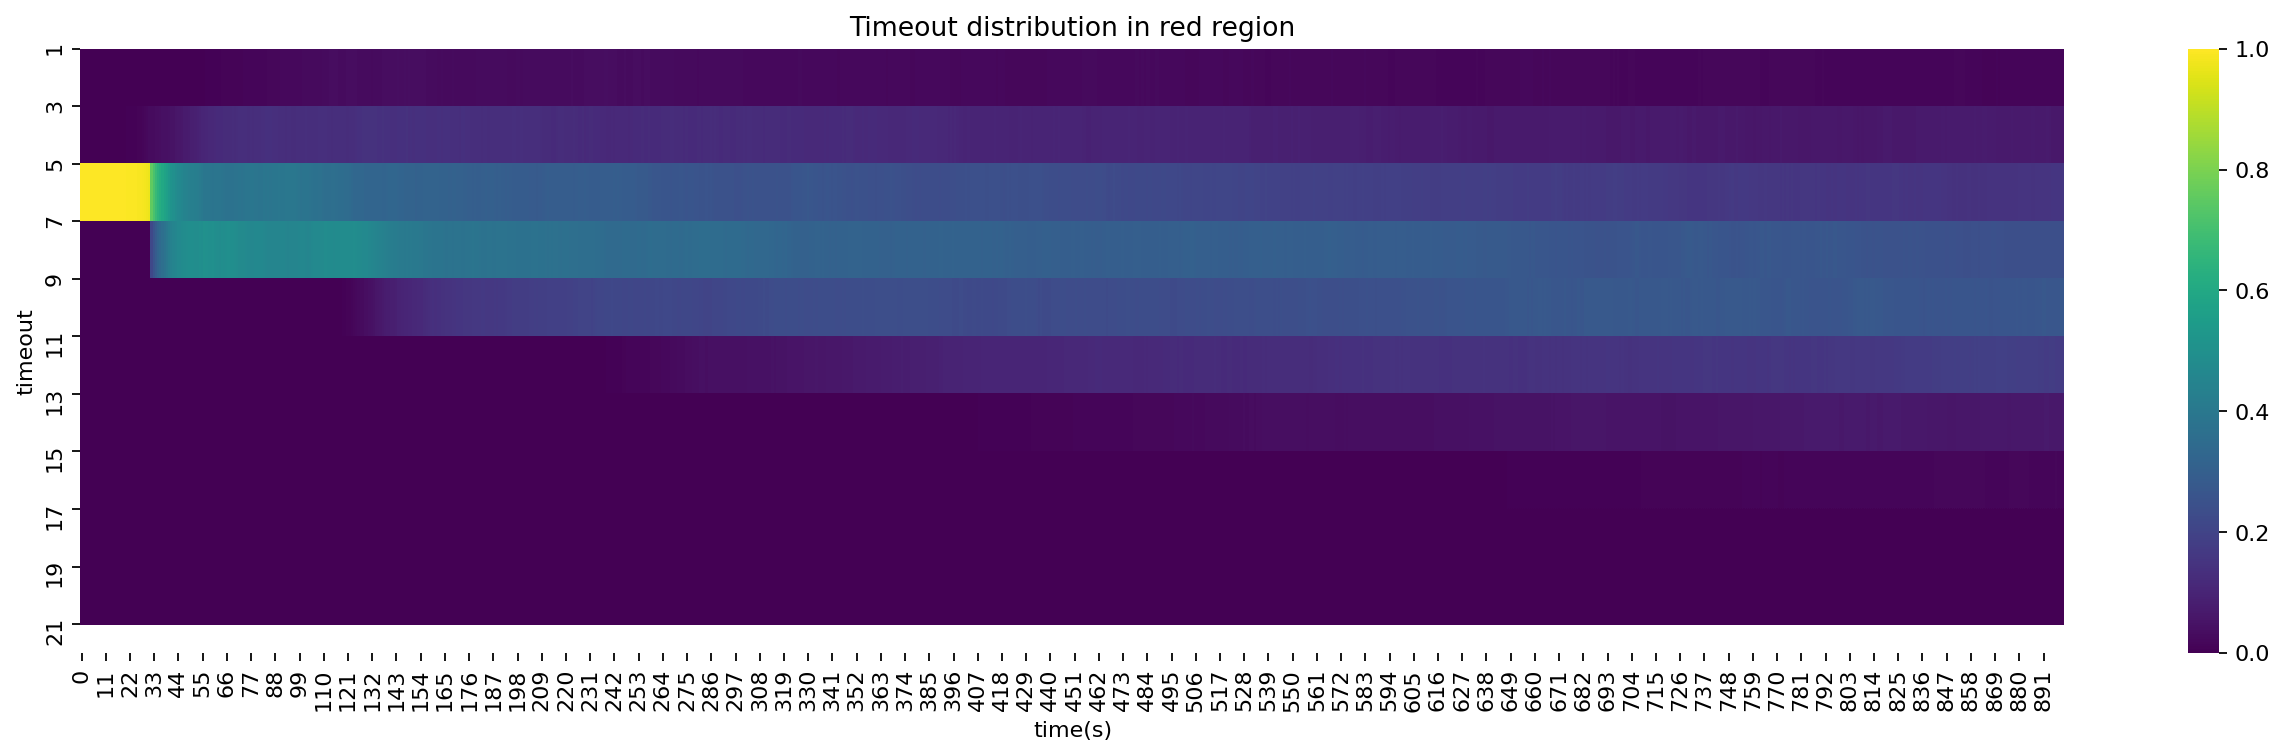

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Regions_Adaptive.png


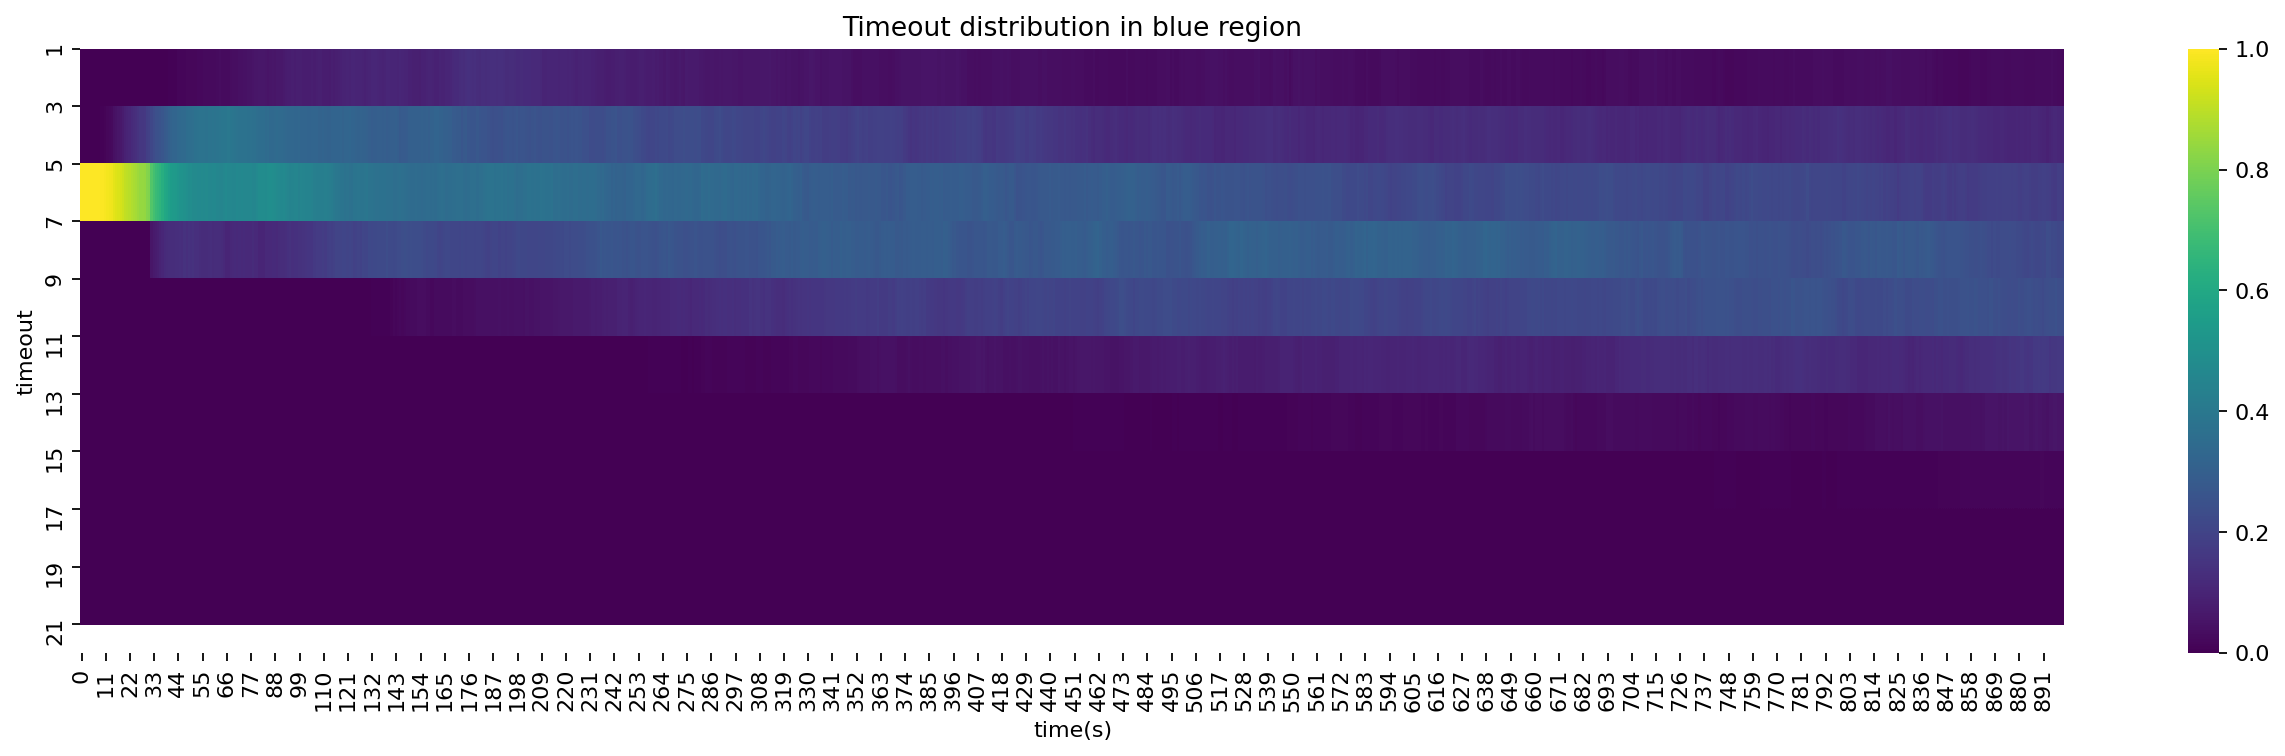

Timeout folder: Regions_Brownian_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Regions_Brownian
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Regions_Brownian.png


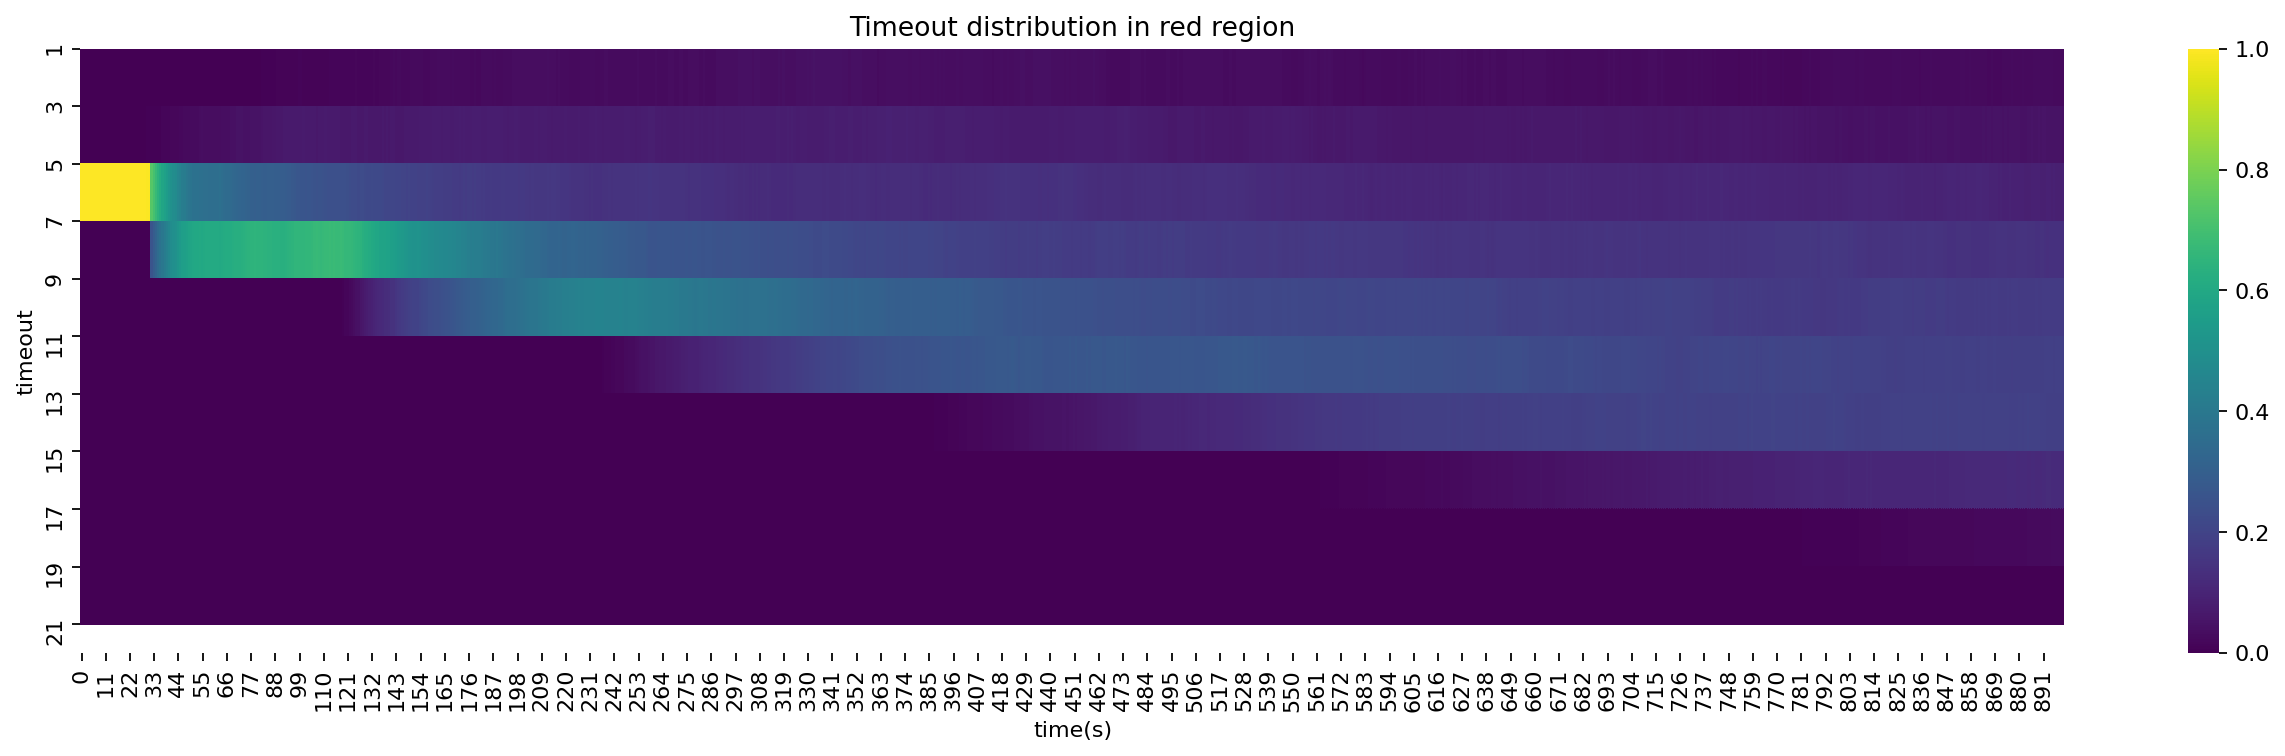

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Regions_Brownian.png


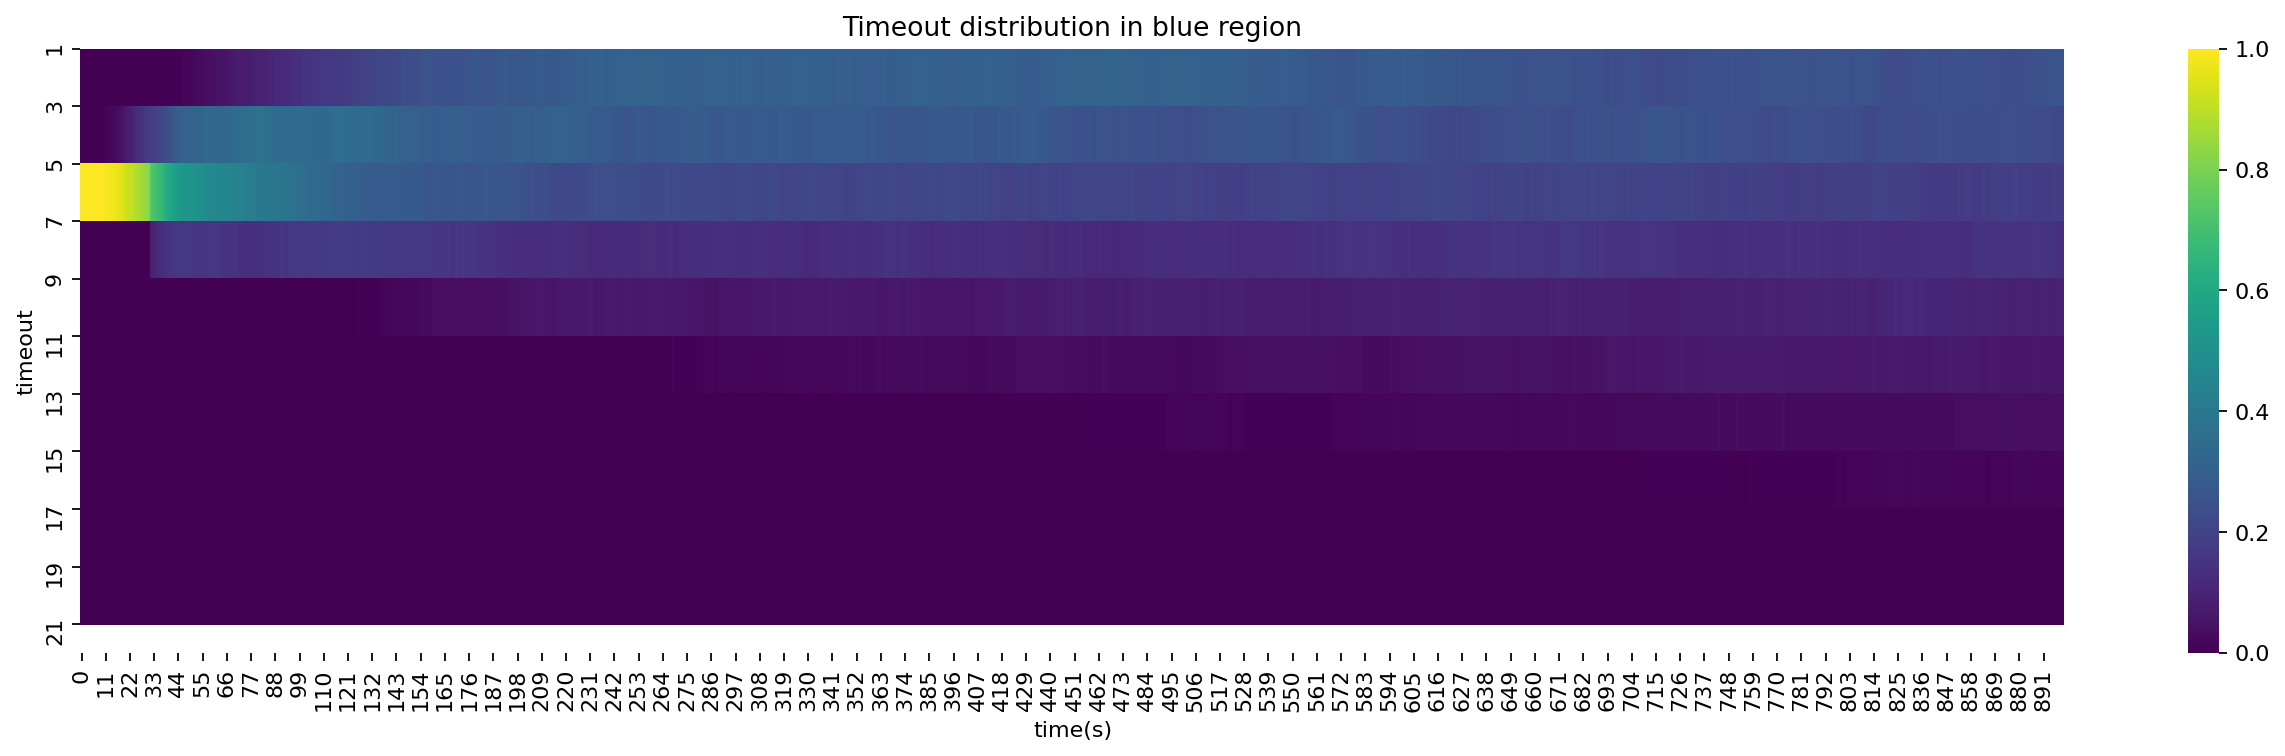

Timeout folder: Regions_Persistent_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Regions_Persistent
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Regions_Persistent.png


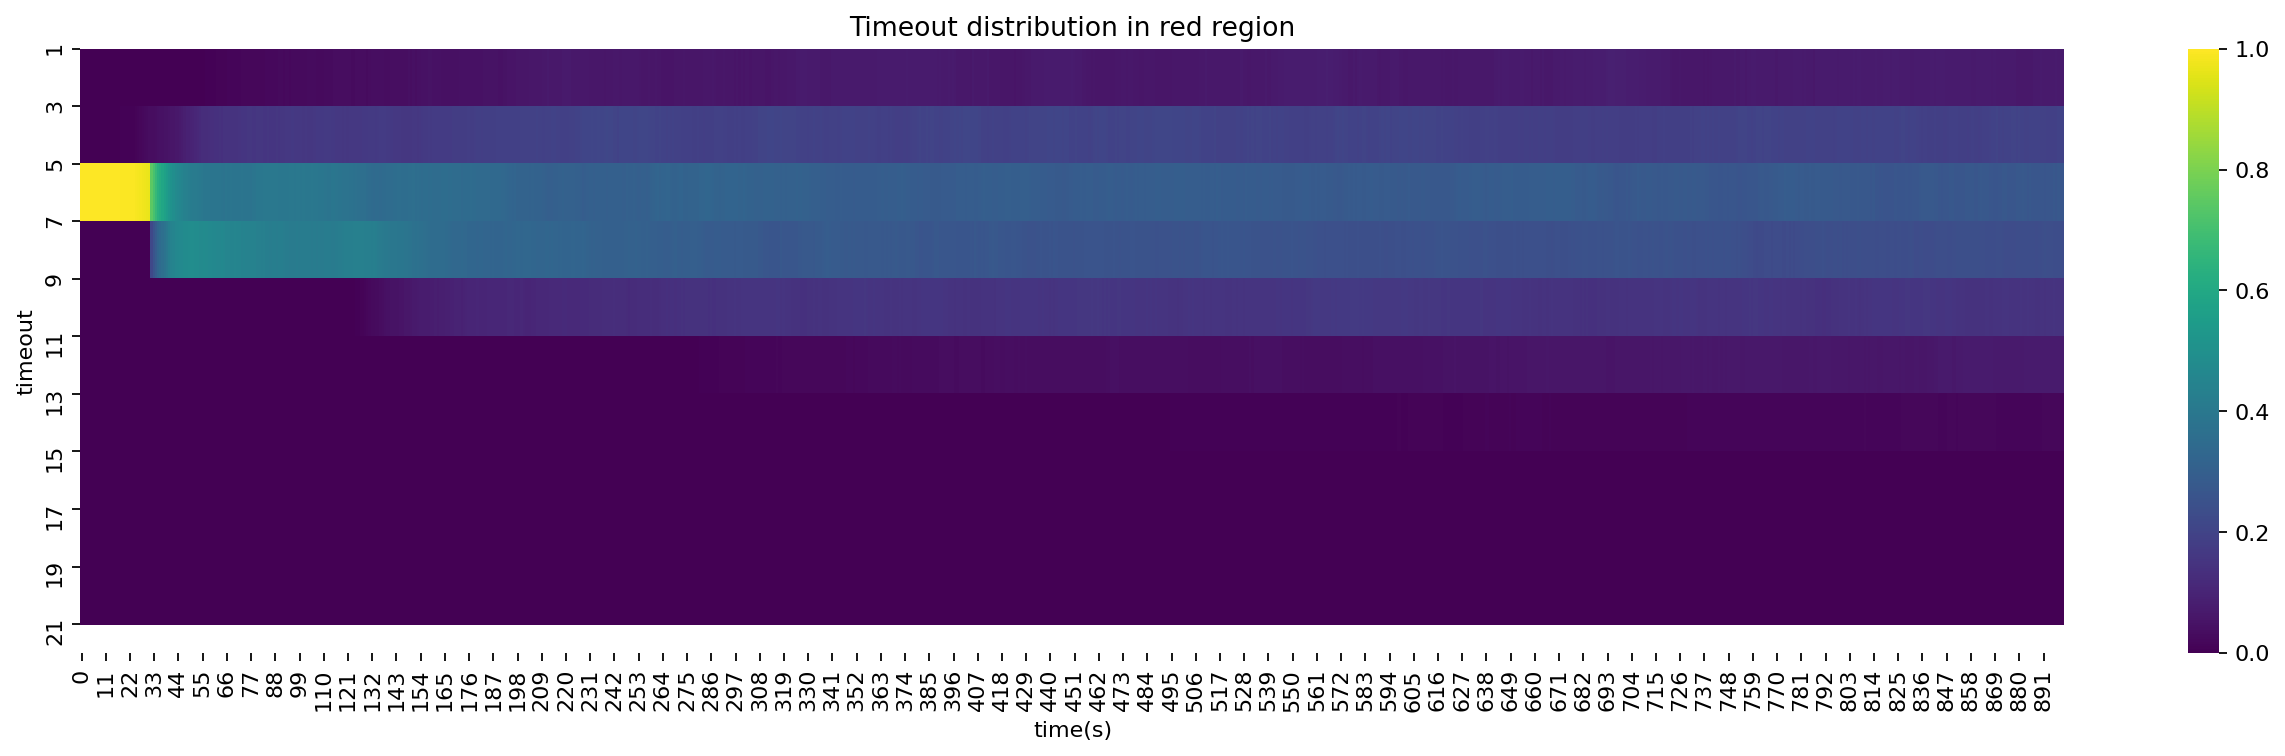

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Regions_Persistent.png


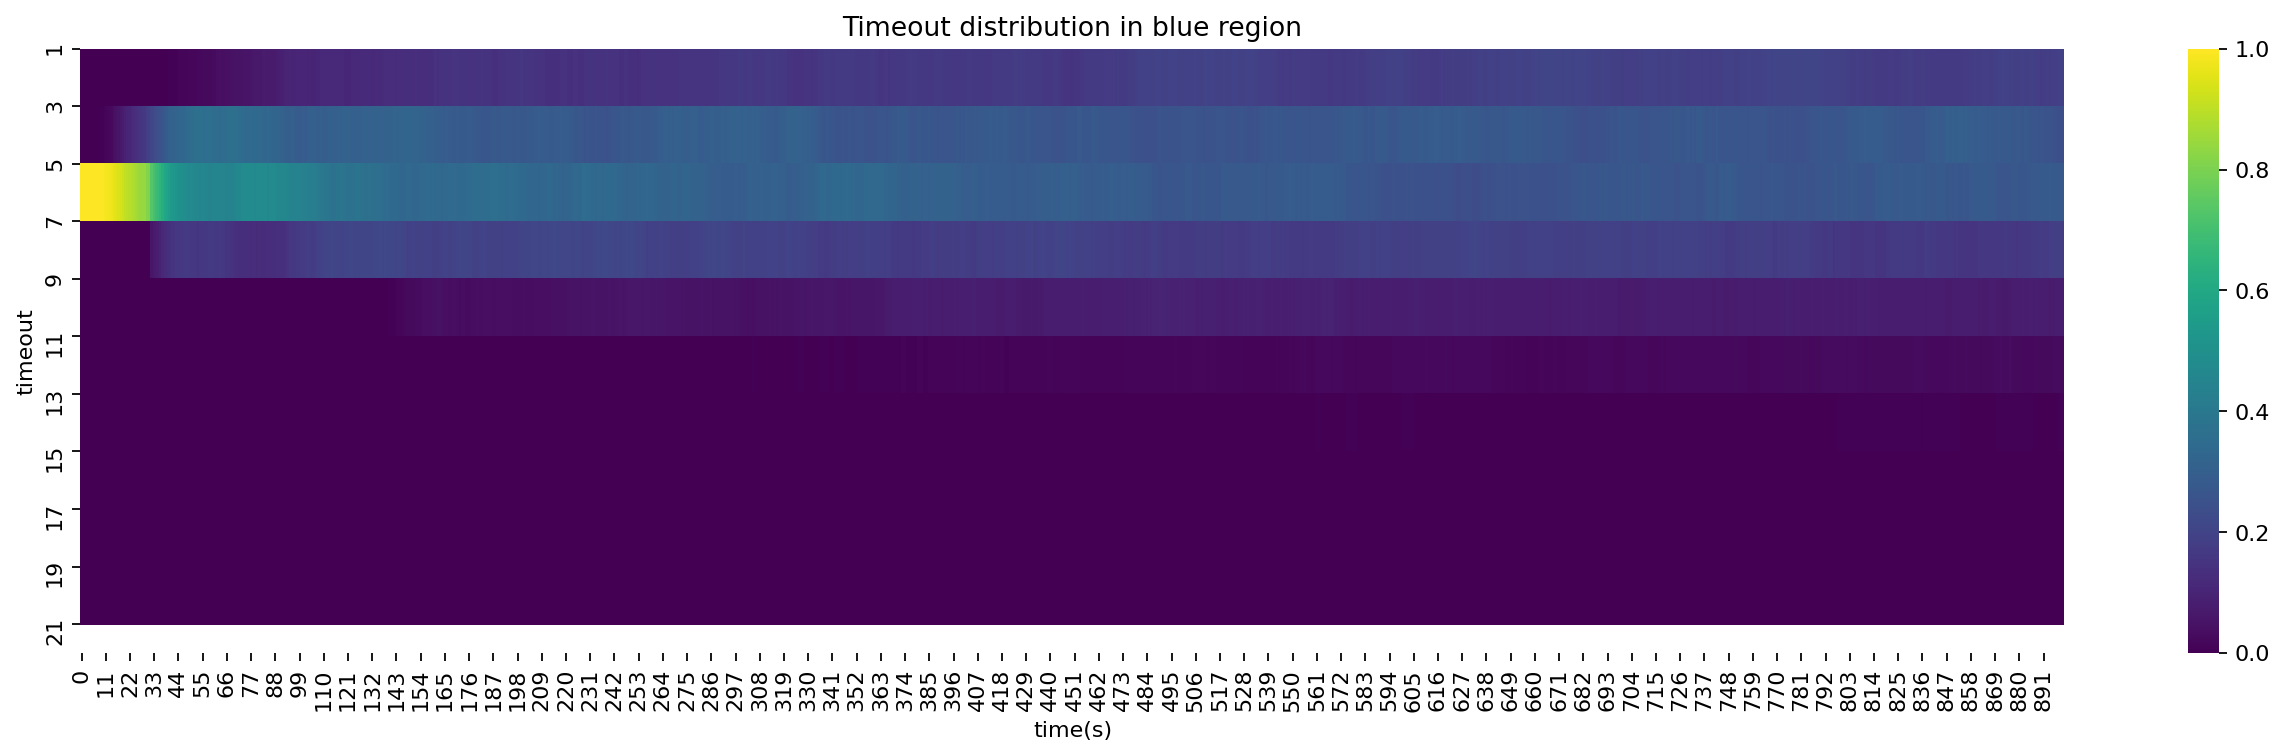

Timeout folder: Mixed_Adaptive_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Mixed_Adaptive
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Mixed_Adaptive.png


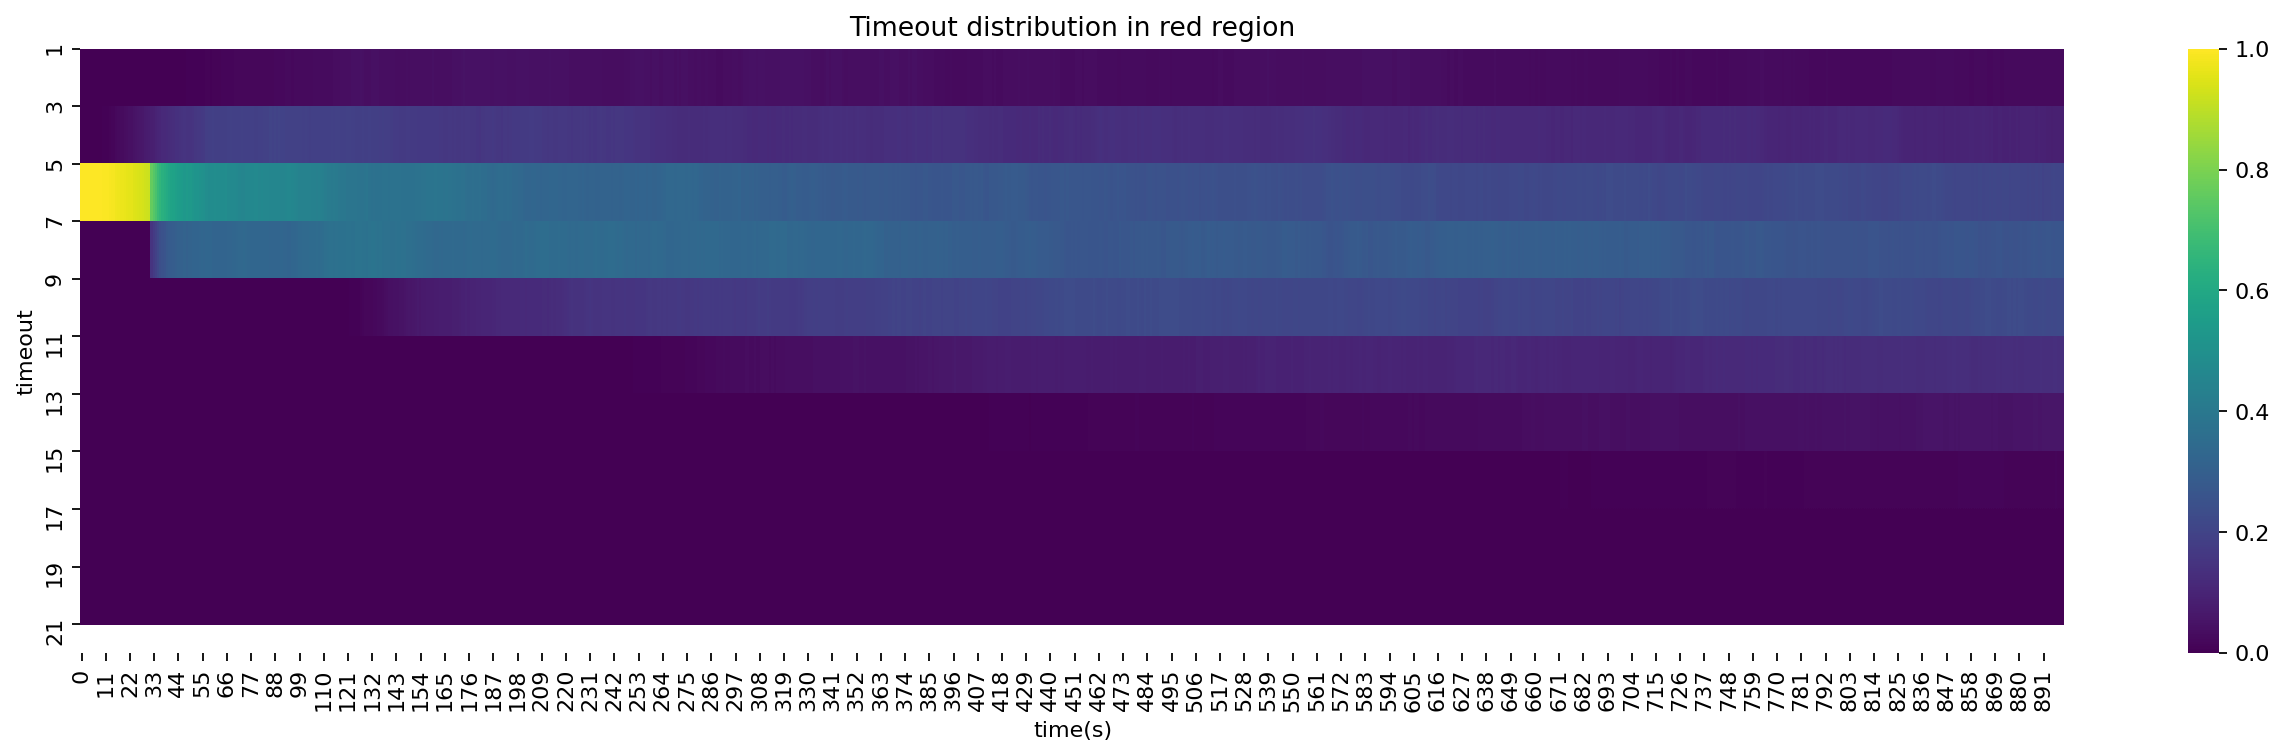

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Mixed_Adaptive.png


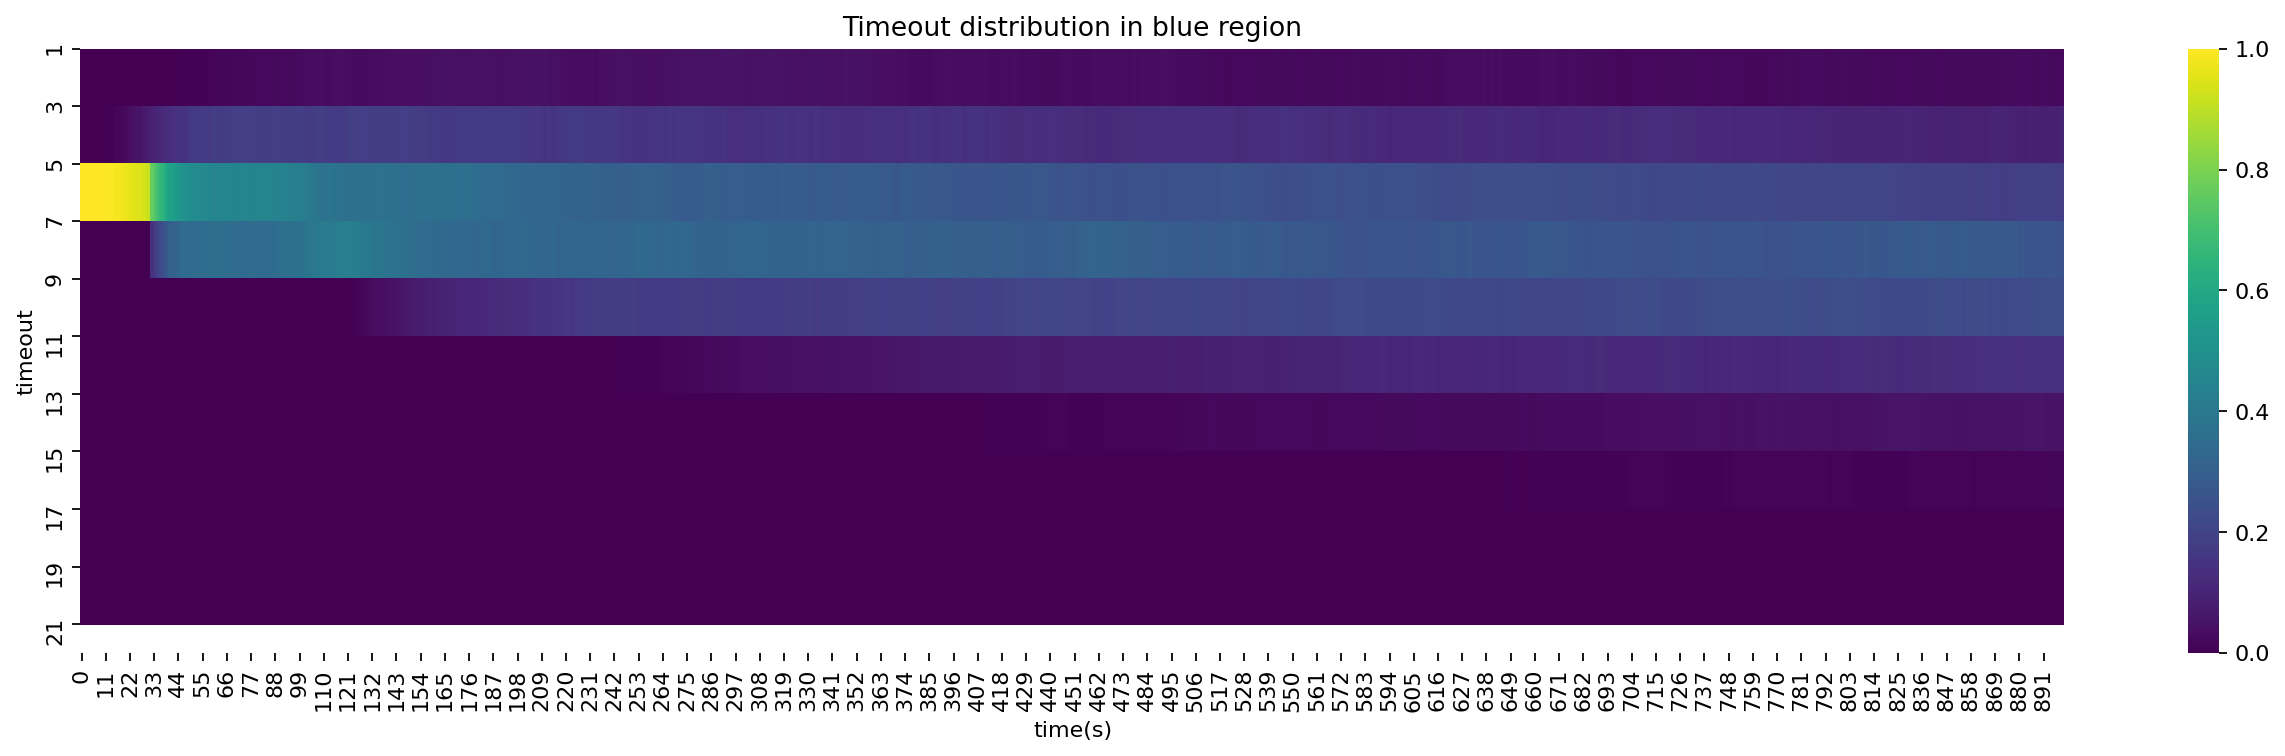

Timeout folder: Mixed_Brownian_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Mixed_Brownian
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Mixed_Brownian.png


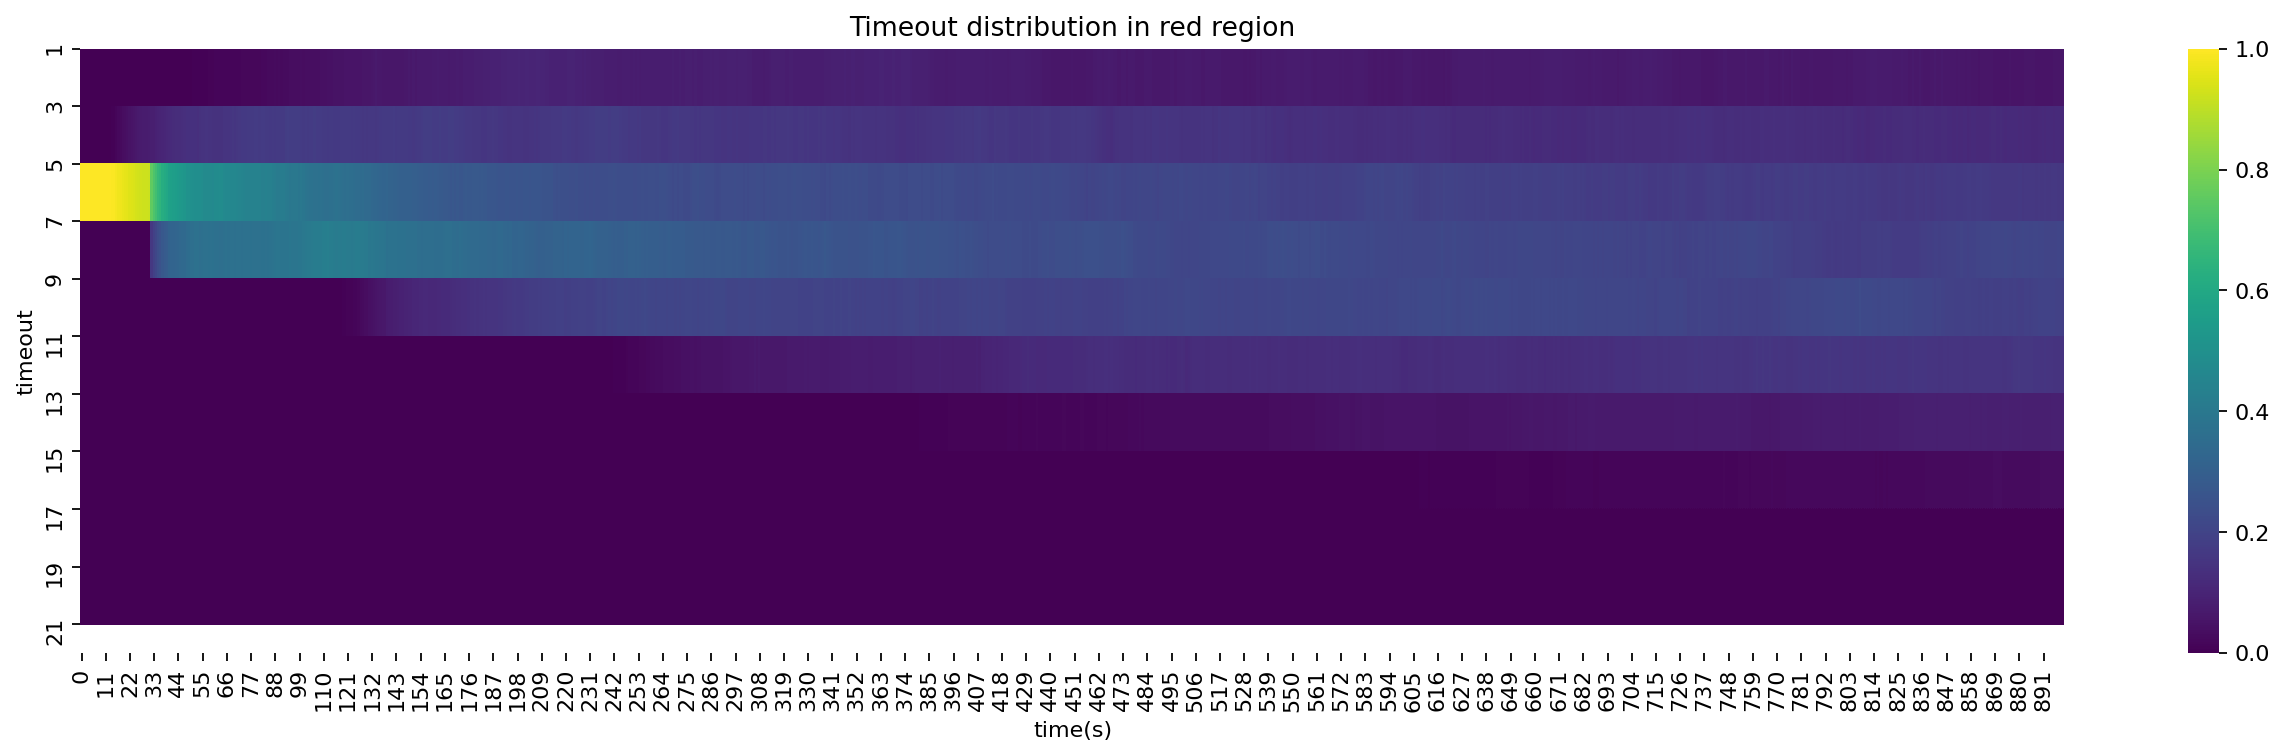

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Mixed_Brownian.png


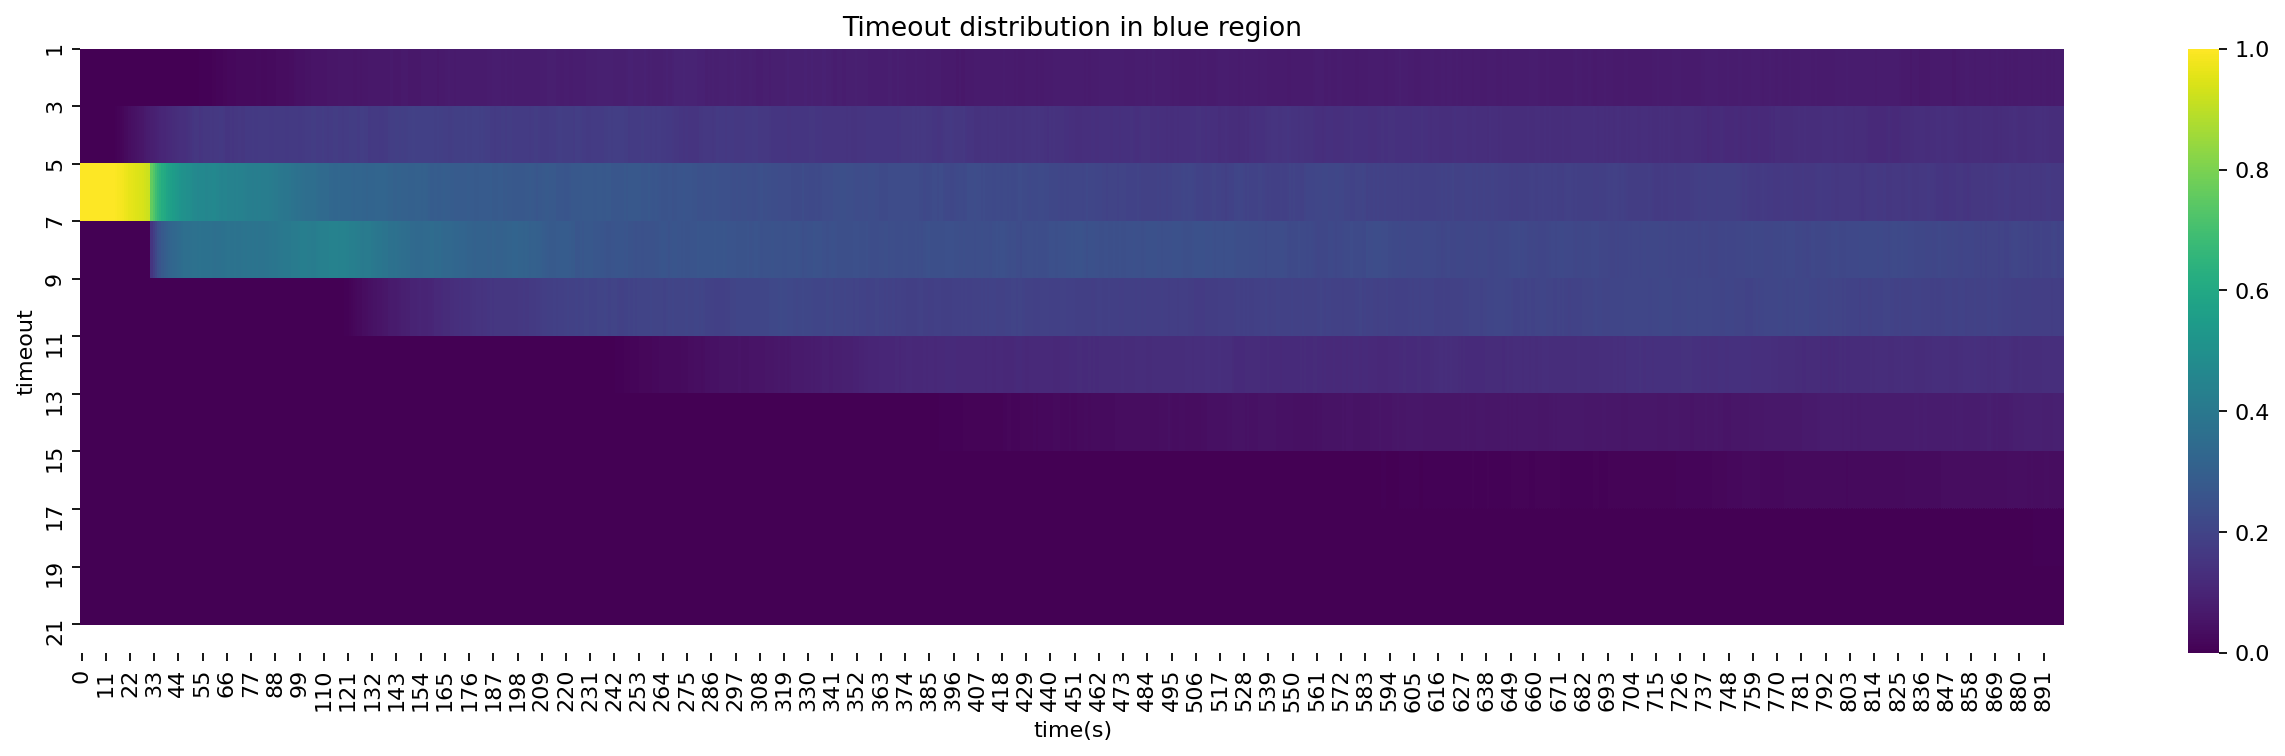

Timeout folder: Mixed_Persistent_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	Exp configuration: Mixed_Persistent
(901, 10)
adaptiveTimeout_timeoutDistribution_red_Mixed_Persistent.png


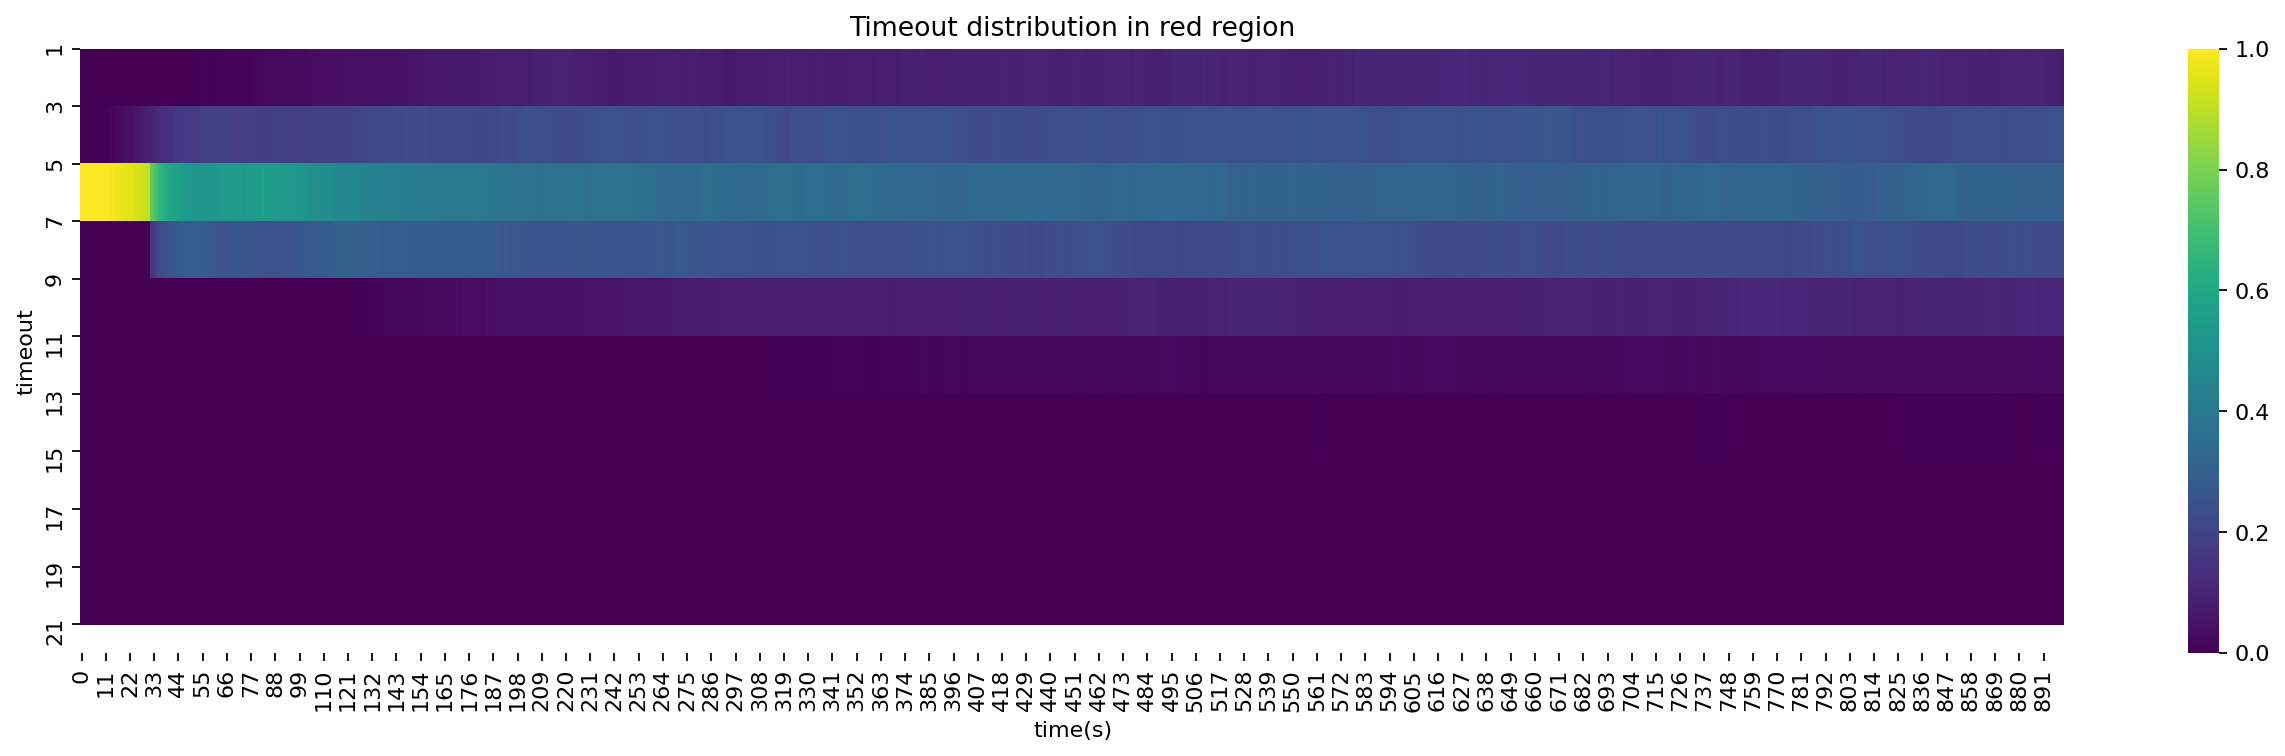

(901, 10)
adaptiveTimeout_timeoutDistribution_blue_Mixed_Persistent.png


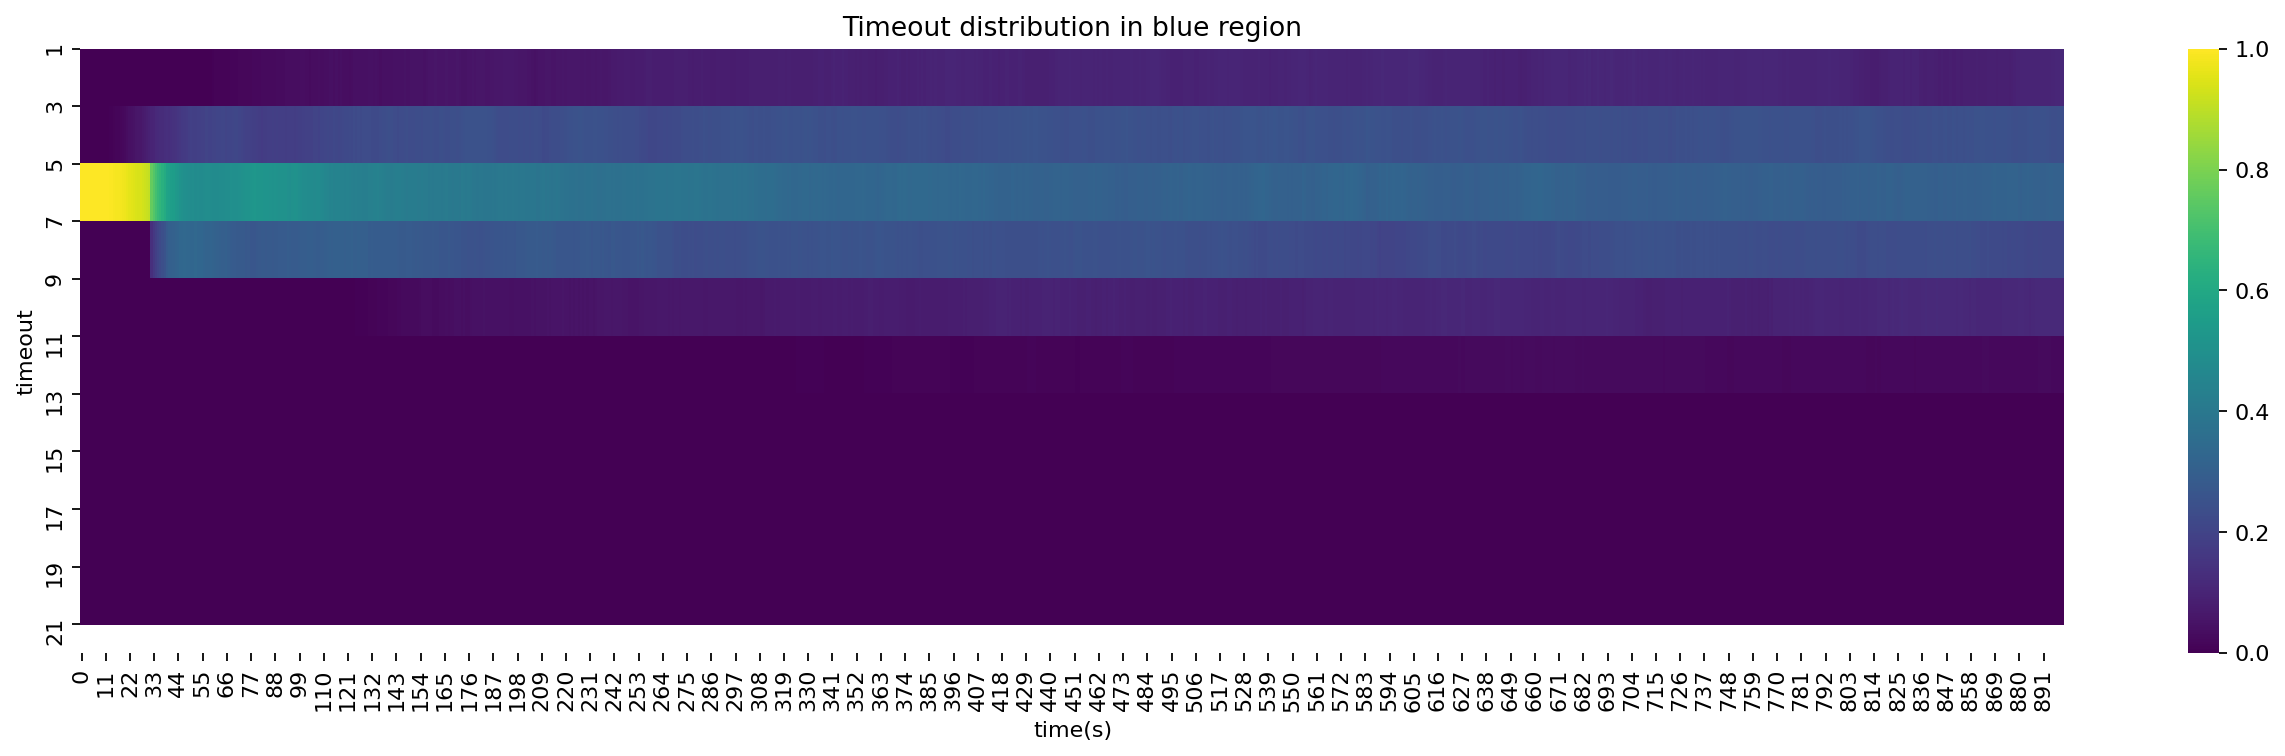

In [9]:
for results_folder in os.listdir(results_folders):
    timeout = -1
    for timeout_folder in natsorted(os.listdir(os.path.join(results_folders,results_folder))):
        print(colored("Timeout folder:", 'blue'),timeout_folder)

        parameters = timeout_folder.split("_")

        for param in parameters:
            if param.startswith("timeout"):
    #             print(param.split("#")[-1])
                timeout = int(param.split("#")[-1]) * 10
    #             print("\ttimeout:",timeout)


        if timeout == -1 :
            print(colored("\tWARNING: wrong timeout folder", 'green'))
            continue

        exp_config = parameters[0]+"_"+parameters[1]
        print("\tExp configuration:",exp_config)
        
        
        timeout_red = np.array([]).astype(int)
        timeout_blue = np.array([]).astype(int)
        for filename in os.listdir(os.path.join(results_folders, results_folder, timeout_folder)):
            if filename.endswith("kiloLOG.tsv"):
                if not os.path.getsize(os.path.join(results_folders, results_folder, timeout_folder, filename)) > 0:
                    print(colored("\tWARNING, empty file at:" + filename, 'red'))
                    continue
#                 print('\tfilename: ', filename)

                df_kiloLOG = pd.read_csv(os.path.join(results_folders, results_folder, timeout_folder, filename), sep="\t", header=None)
                df_kiloLOG.columns = kiloLOG_label
        
                for k in range(1, num_robot*fieldsPerKilobot, fieldsPerKilobot):
#                     print(df_kiloLOG.iloc[:5,k:k+fieldsPerKilobot])

                    df_k = df_kiloLOG.iloc[:,k:k+fieldsPerKilobot]
                    
                    df_kiloRED = df_k.where(df_k["posx"+str(k//fieldsPerKilobot)] > 0) 
                    timeout_red = np.vstack([timeout_red,df_kiloRED["timer"+str(k//fieldsPerKilobot)].values]) if timeout_red.size else df_kiloRED["timer"+str(k//fieldsPerKilobot)].values
                    
                    df_kiloBLUE = df_k.where(df_k["posx"+str(k//fieldsPerKilobot)] < 0) 
                    timeout_blue = np.vstack([timeout_blue,df_kiloBLUE["timer"+str(k//fieldsPerKilobot)].values]) if timeout_blue.size else df_kiloBLUE["timer"+str(k//fieldsPerKilobot)].values
#                     print(df_kiloBLUE["timer"+str(k//fieldsPerKilobot)].iloc[:5])
        
        histogram_red = get_histogram(timeout_red, bin_edges)
        plot_heatmap(histogram_red, bin_edges,exp_config, "red")
        
        histogram_blue = get_histogram(timeout_blue, bin_edges)
        plot_heatmap(histogram_blue, bin_edges,exp_config, "blue")
